# Exploring Wage Mobility Challenge in the Model
My hunch is that the reason we are over-estimating the unemployment rate in high-ranking occupations is because the wage options are limited. Below, I plot some facts about the relationships between the median wage of each occupation and their "transition options" using the occupational mobility network. 

Interestingly, the wage "options" for most occupations are below the 45-degree line in Plot 1. As expected, the top (bottom) 15 occupations in terms of potential wage gain from a transition are low (high) skill and likely pay. It certainly makes sense that higher-wage earners have less higher-wage options in theory but this should then be offset with a lower chance of being separated (which could be incorporated according to Vasco Carvalho's advice regarding accumulating industry-specific capital or expertise).


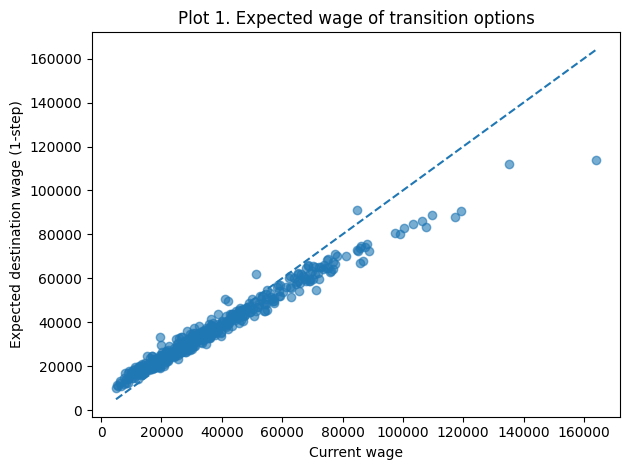

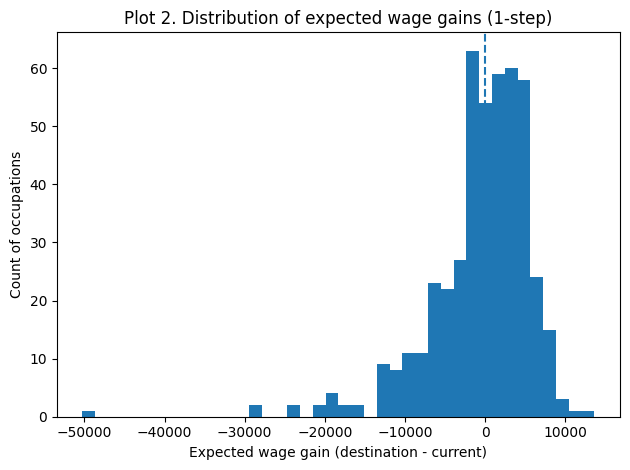

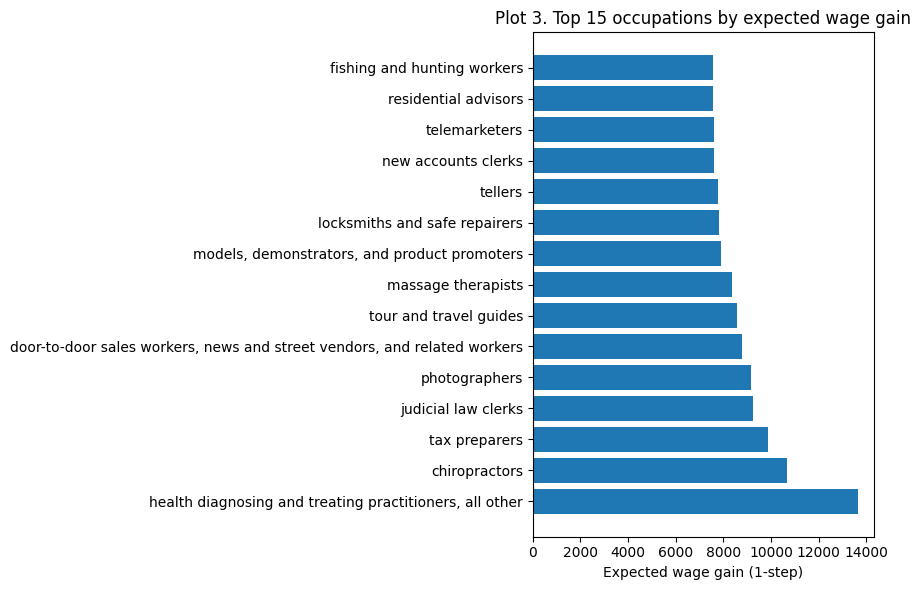

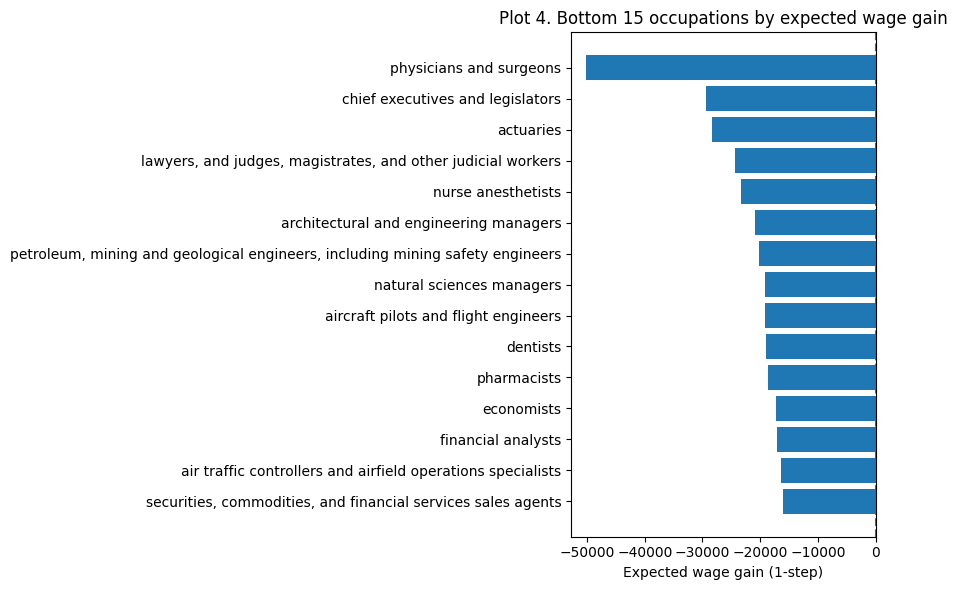

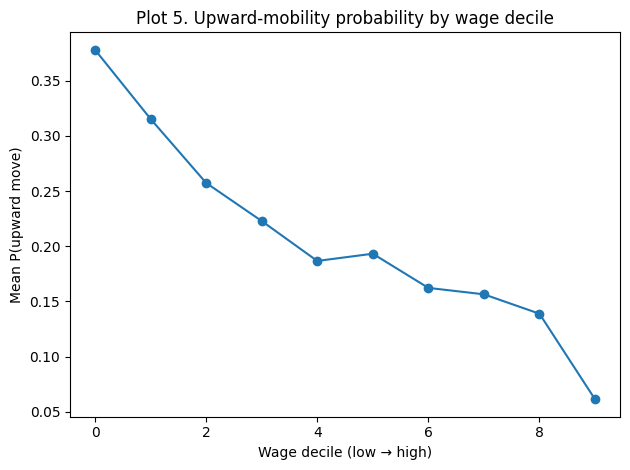

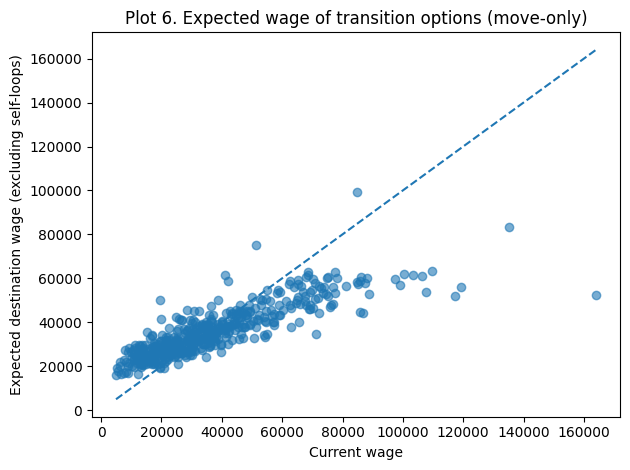

In [4]:
# ===== Mobility & Wage Diagnostics (copy-paste ready) =====
# Requirements: pandas, numpy, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Load data ----------
# Set your path first (expects the two CSVs below to exist at this path)
path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/"


A = pd.read_csv(path + "dRC_Replication/data/occupational_mobility_network.csv", header=None)
wages_df = pd.read_csv(path + "dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
labels = pd.read_csv(path + "dRC_Replication/data/ipums_variables.csv")[['label']]

# Optional: if you also have occupation names/codes, load & align them here and
# store in `occ_labels` (list/Series of length N). Otherwise we’ll use indices.
occ_labels = labels['label'].tolist()

# ---------- 1) Prep & sanity checks ----------
w = wages_df['median_earnings'].astype(float).to_numpy()
N = w.shape[0]
assert A.shape[0] == A.shape[1] == N, "A must be square and match the length of wages."

# Handle non-finite wages for log computations later
valid_w = np.isfinite(w) & (w > 0)
if not np.all(valid_w):
    # You can choose a different strategy: drop, impute, etc.
    # Here we simple-impute nonpositive/NaN wages with the median of valid wages.
    w_impute = np.nanmedian(w[valid_w])
    w = np.where(valid_w, w, w_impute)

# Ensure rows of A are probabilities (row-stochastic)
row_sums = A.sum(axis=1).replace(0, np.nan)            # avoid divide-by-zero
A_prob = A.div(row_sums, axis=0).fillna(0.0)
A_prob_np = A_prob.to_numpy(dtype=float)

# ---------- 2) Core metrics ----------
# Expected destination wage (1-step): E[w_dest | i] = sum_j A_ij * w_j
expected_dest_wage = A_prob_np @ w

# Expected wage gain vs current
current_wage = w
expected_gain = expected_dest_wage - current_wage

# Expected log change (≈ expected % change for small changes)
logw = np.log(np.clip(w, 1e-9, None))
expected_log_change = (A_prob_np @ logw) - logw

# Probability of an "upward move" (higher destination wage than current)
w_i = w[:, None]
w_j = w[None, :]
upward_mask = (w_j > w_i).astype(float)
prob_upward = (A_prob_np * upward_mask).sum(axis=1)

# Probability of achieving at least X% wage gain in one move
X = 0.10  # 10% threshold; change as needed
threshold_mask = (w_j >= (1 + X) * w_i).astype(float)
prob_gain_X = (A_prob_np * threshold_mask).sum(axis=1)

# ---------- 3) “Move-only” expected destination wage (exclude self-loops) ----------
A_excl_self = A_prob_np.copy()
np.fill_diagonal(A_excl_self, 0.0)
row_sums_excl = A_excl_self.sum(axis=1, keepdims=True)
# Re-normalize rows where there is some probability mass after removing self-loop
safe = row_sums_excl.squeeze() > 0
A_excl_self[safe] = A_excl_self[safe] / row_sums_excl[safe]
expected_dest_wage_move_only = A_excl_self @ w

# ---------- 4) Helper: top destinations for a given occupation ----------
def top_transitions_for(i, k=10):
    probs = A_prob_np[i]
    idx = np.argsort(probs)[::-1][:k]
    return pd.DataFrame({
        'dest_index': idx,
        'dest_label': [occ_labels[j] for j in idx],
        'transition_prob': probs[idx],
        'dest_wage': w[idx],
        'wage_change_vs_i': w[idx] - w[i],
        'log_change_vs_i': np.log(np.clip(w[idx], 1e-9, None)) - np.log(np.clip(w[i], 1e-9, None))
    })

# Example (uncomment to inspect):
# print(top_transitions_for(42, k=10))

# ---------- 5) Optional: expected wages after n steps ----------
def expected_wage_after_n_steps(A_prob_np, w, n=2):
    An = np.linalg.matrix_power(A_prob_np, n)
    return An @ w

exp_wage_2step = expected_wage_after_n_steps(A_prob_np, w, n=2)
exp_gain_2step = exp_wage_2step - w

# ---------- 6) Pack results into a tidy DataFrame ----------
results = pd.DataFrame({
    'occ_index': np.arange(N),
    'occ_label': occ_labels,
    'current_wage': current_wage,
    'expected_dest_wage_1step': expected_dest_wage,
    'expected_gain_1step': expected_gain,
    'expected_log_change_1step': expected_log_change,
    'prob_upward': prob_upward,
    f'prob_gain_>{int(X*100)}pct': prob_gain_X,
    'expected_dest_wage_move_only': expected_dest_wage_move_only,
    'expected_wage_2step': exp_wage_2step,
    'expected_gain_2step': exp_gain_2step
})

# Sortable convenience views (uncomment to explore)
# print(results.sort_values('expected_gain_1step').head(10))
# print(results.sort_values('expected_gain_1step', ascending=False).head(10))

# ---------- 7) Charts ----------
# Tip: If you have occupation names, swap x/y tick labels accordingly.

# 7.1 Scatter: current wage vs. expected destination wage (1-step)
plt.figure()
plt.scatter(results['current_wage'], results['expected_dest_wage_1step'], alpha=0.6)
min_w = min(results['current_wage'].min(), results['expected_dest_wage_1step'].min())
max_w = max(results['current_wage'].max(), results['expected_dest_wage_1step'].max())
plt.plot([min_w, max_w], [min_w, max_w], linestyle='--')  # 45° line
plt.xlabel('Current wage')
plt.ylabel('Expected destination wage (1-step)')
plt.title('Plot 1. Expected wage of transition options')
plt.tight_layout()

# 7.2 Histogram: distribution of expected gains (1-step)
plt.figure()
plt.hist(results['expected_gain_1step'], bins=40)
plt.axvline(0, linestyle='--')
plt.xlabel('Expected wage gain (destination - current)')
plt.ylabel('Count of occupations')
plt.title('Plot 2. Distribution of expected wage gains (1-step)')
plt.tight_layout()

# 7.3 Ranked bar charts: Top/bottom by expected gain (1-step)
k = 15  # top/bottom count
order = np.argsort(results['expected_gain_1step'].to_numpy())
bottom_idx = order[:k]
top_idx = order[-k:]

def bar_helper(idxs, title):
    plt.figure(figsize=(9, 6))
    labels = results['occ_label'].iloc[idxs]
    vals = results['expected_gain_1step'].iloc[idxs]
    plt.barh(labels, vals)
    plt.axvline(0, linestyle='--')
    plt.title(title)
    plt.xlabel('Expected wage gain (1-step)')
    plt.gca().invert_yaxis()
    plt.tight_layout()

bar_helper(top_idx,  f'Plot 3. Top {k} occupations by expected wage gain')
bar_helper(bottom_idx, f'Plot 4. Bottom {k} occupations by expected wage gain')

# 7.4 Upward-mobility curve: mean P(upward) by wage decile
# (If many ties, qcut may drop bins; duplicates='drop' handles that.)
deciles = pd.qcut(results['current_wage'], 10, labels=False, duplicates='drop')
mobility_df = pd.DataFrame({
    'decile': deciles,
    'prob_upward': results['prob_upward'],
    'elog_change': results['expected_log_change_1step']
}).groupby('decile', as_index=True).mean()

plt.figure()
plt.plot(mobility_df.index, mobility_df['prob_upward'], marker='o')
plt.xlabel('Wage decile (low → high)')
plt.ylabel('Mean P(upward move)')
plt.title('Plot 5. Upward-mobility probability by wage decile')
plt.tight_layout()

# 7.5 Optional: compare current wage vs. "move-only" expected destination wage
plt.figure()
plt.scatter(results['current_wage'], results['expected_dest_wage_move_only'], alpha=0.6)
lo = min(results['current_wage'].min(), results['expected_dest_wage_move_only'].min())
hi = max(results['current_wage'].max(), results['expected_dest_wage_move_only'].max())
plt.plot([lo, hi], [lo, hi], linestyle='--')
plt.xlabel('Current wage')
plt.ylabel('Expected destination wage (excluding self-loops)')
plt.title('Plot 6. Expected wage of transition options (move-only)')
plt.tight_layout()

plt.show()

# ---------- 8) (Optional) Sparsify A for heatmap/network views ----------
# Keep only top-k probabilities per row to reduce noise in visualizations
def topk_sparsify(A_prob_np, k=10):
    A_sparse = np.zeros_like(A_prob_np)
    for i in range(A_prob_np.shape[0]):
        idx = np.argsort(A_prob_np[i])[::-1][:k]
        A_sparse[i, idx] = A_prob_np[i, idx]
    return A_sparse

# Example usage (uncomment to compute):
# A_topk = topk_sparsify(A_prob_np, k=10)
# You can then visualize A_topk with your preferred heatmap tool (e.g., matplotlib.imshow).

# ----- End of script -----